In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
data = pd.read_csv('../data/train.csv')
data_to_predict = pd.read_csv('../data/test.csv')

In [71]:
X = data.drop(['loan_status'], axis=1)
y = data['loan_status']

# Preprocessing

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [74]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('id')

In [75]:
categorical_ordinal = ['loan_grade']
categorical_onehot = categorical_columns.drop(categorical_ordinal)

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
	transformers=[
		('ordinal', OrdinalEncoder(), categorical_ordinal),
		('onehot', OneHotEncoder(), categorical_onehot),
		('scaler', StandardScaler(), numerical_columns)
	])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(), ['loan_grade']),
                                ('onehot', OneHotEncoder(),
                                 Index(['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], dtype='object')),
                                ('scaler', StandardScaler(),
                                 Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))])

In [77]:
X_train_prep = preprocessor.transform(X_train)

In [78]:
X_test_prep = preprocessor.transform(X_test)

# XGBoost

In [79]:
import xgboost as xgb

In [80]:
dtrain = xgb.DMatrix(X_train_prep, label=y_train)
dtest = xgb.DMatrix(X_test_prep, label=y_test)

In [81]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'evals'), (dtrain, 'train')]

In [82]:
num_round = 200
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	evals-auc:0.84874	train-auc:0.85211
[1]	evals-auc:0.89404	train-auc:0.89603
[2]	evals-auc:0.91506	train-auc:0.91204
[3]	evals-auc:0.91151	train-auc:0.90937
[4]	evals-auc:0.91567	train-auc:0.91377
[5]	evals-auc:0.92012	train-auc:0.91799
[6]	evals-auc:0.92433	train-auc:0.92331
[7]	evals-auc:0.92531	train-auc:0.92412


c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	evals-auc:0.92577	train-auc:0.92468
[9]	evals-auc:0.92615	train-auc:0.92539
[10]	evals-auc:0.92894	train-auc:0.92867
[11]	evals-auc:0.93016	train-auc:0.92975
[12]	evals-auc:0.93167	train-auc:0.93232
[13]	evals-auc:0.93221	train-auc:0.93316
[14]	evals-auc:0.93251	train-auc:0.93337
[15]	evals-auc:0.93540	train-auc:0.93648
[16]	evals-auc:0.93587	train-auc:0.93739
[17]	evals-auc:0.93658	train-auc:0.93788
[18]	evals-auc:0.93690	train-auc:0.93849
[19]	evals-auc:0.93832	train-auc:0.94010
[20]	evals-auc:0.93911	train-auc:0.94100
[21]	evals-auc:0.93925	train-auc:0.94135
[22]	evals-auc:0.94027	train-auc:0.94225
[23]	evals-auc:0.94087	train-auc:0.94260
[24]	evals-auc:0.94117	train-auc:0.94300
[25]	evals-auc:0.94142	train-auc:0.94359
[26]	evals-auc:0.94217	train-auc:0.94404
[27]	evals-auc:0.94431	train-auc:0.94584
[28]	evals-auc:0.94504	train-auc:0.94679
[29]	evals-auc:0.94493	train-auc:0.94705
[30]	evals-auc:0.94497	train-auc:0.94722
[31]	evals-auc:0.94600	train-auc:0.94822
[32]	evals-auc:0.9

## Cross Validation

In [83]:
cv_results = xgb.cv(param, dtrain, num_round, nfold=5, metrics={'auc'}, early_stopping_rounds=10)

In [84]:
cv_results = pd.DataFrame(cv_results)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.852115,0.001657,0.852133,0.006689
1,0.896010,0.001020,0.895922,0.004115
2,0.909599,0.005579,0.908656,0.004375
3,0.911986,0.002143,0.910645,0.004066
4,0.915743,0.001904,0.914177,0.003974
...,...,...,...,...
122,0.964160,0.001351,0.953903,0.001849
123,0.964199,0.001349,0.954030,0.001753
124,0.964273,0.001387,0.954096,0.001783
125,0.964377,0.001392,0.954260,0.001760


## Hyperparameter Tuning

In [85]:
from sklearn.model_selection import GridSearchCV

In [40]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
						   scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train_prep, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best AUC Score: 0.9528388314968684


In [41]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [200, 300, 500],
	'subsample': [0.8],
    'colsample_bytree': [0.8],             
    'gamma': [0, 0.1, 0.3],                     
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
						   scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train_prep, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best AUC Score: 0.9543454696625759


In [89]:
best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_

best_xgb_model.fit(X_train_prep, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [90]:
# Cross val best model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_xgb_model, X_train_prep, y_train, cv=5, scoring='roc_auc')

In [91]:
print("Cross Val AUC:", scores.mean())
print("Cross Val AUC Std:", scores.std())

Cross Val AUC: 0.9554847978732038
Cross Val AUC Std: 0.0032938031171310315


In [93]:
# Predictions on the test set and roc_auc_score
from sklearn.metrics import roc_auc_score

y_preds = best_xgb_model.predict(X_test_prep)

roc_auc_score(y_test, y_preds)

0.8615434802814104

In [105]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_test = best_model.predict(X_test_prep)
y_proba_test = best_model.predict_proba(X_test_prep)[:, 1]

In [108]:
from sklearn.metrics import roc_auc_score

thresholds = np.linspace(0, 1, 100)

best_AUC = 0

for threshold in thresholds:
	y_pred_test_th = (y_proba_test > threshold).astype(int)
	auc = roc_auc_score(y_test, y_pred_test_th)
	print(f"Threshold: {threshold:.2f}, AUC: {auc:.10f}")
	if auc > best_AUC:
		best_AUC = auc
		best_threshold = threshold

print(f"Best AUC: {best_AUC:.10f}, Best Threshold: {best_threshold:.2f}")

Threshold: 0.00, AUC: 0.5000000000
Threshold: 0.01, AUC: 0.6896571185
Threshold: 0.02, AUC: 0.7698178220
Threshold: 0.03, AUC: 0.8095117235
Threshold: 0.04, AUC: 0.8368647931
Threshold: 0.05, AUC: 0.8558506977
Threshold: 0.06, AUC: 0.8665781463
Threshold: 0.07, AUC: 0.8740680757
Threshold: 0.08, AUC: 0.8792697995
Threshold: 0.09, AUC: 0.8820756717
Threshold: 0.10, AUC: 0.8844854651
Threshold: 0.11, AUC: 0.8880619900
Threshold: 0.12, AUC: 0.8888175164
Threshold: 0.13, AUC: 0.8901660980
Threshold: 0.14, AUC: 0.8889702983
Threshold: 0.15, AUC: 0.8898237814
Threshold: 0.16, AUC: 0.8892511680
Threshold: 0.17, AUC: 0.8868186852
Threshold: 0.18, AUC: 0.8862363825
Threshold: 0.19, AUC: 0.8862277563
Threshold: 0.20, AUC: 0.8860706004
Threshold: 0.21, AUC: 0.8868143113
Threshold: 0.22, AUC: 0.8862610767
Threshold: 0.23, AUC: 0.8849458156
Threshold: 0.24, AUC: 0.8849662574
Threshold: 0.25, AUC: 0.8840664538
Threshold: 0.26, AUC: 0.8827608820
Threshold: 0.27, AUC: 0.8811388724
Threshold: 0.28, AUC

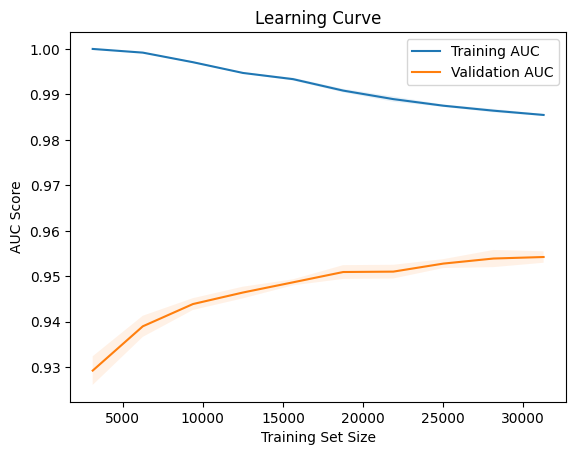

In [49]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_prep, y_train, cv=3, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training AUC')
plt.plot(train_sizes, test_scores_mean, label='Validation AUC')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [96]:
cv_results = grid_search.cv_results_
print("Cross-validation AUC scores per fold:", cv_results['split0_test_score'], cv_results['split1_test_score'], cv_results['split2_test_score'])

Cross-validation AUC scores per fold: [0.95569384 0.95599149 0.95409042 0.95264279 0.95163693 0.94911441
 0.95276127 0.95108145 0.94737495 0.94809542 0.94675645 0.94460911
 0.943201   0.94148349 0.94026603 0.94151744 0.94154478 0.93991842
 0.95574145 0.95538996 0.9534853  0.95298223 0.95129267 0.94819899
 0.95267444 0.95069903 0.94906938 0.9481193  0.94626713 0.94466931
 0.94368038 0.94002951 0.94021191 0.94124367 0.94065357 0.94047857
 0.95568214 0.9558936  0.95365404 0.95365049 0.95171971 0.94846134
 0.9519253  0.95032998 0.94662835 0.94899539 0.94718073 0.94598492
 0.94320667 0.94055157 0.94004468 0.93969847 0.94068509 0.94083834] [0.95266471 0.95362947 0.95240236 0.95250194 0.95146443 0.94816991
 0.95200765 0.95076658 0.94821154 0.94865595 0.94707046 0.94559555
 0.94204345 0.94063753 0.93915482 0.9411709  0.9400134  0.93956998
 0.95277356 0.95321692 0.95148818 0.95231794 0.95071542 0.94748089
 0.95174397 0.95045163 0.94742308 0.94778395 0.94649204 0.94532959
 0.94220198 0.94014149 

In [109]:
num_round = 300
evallist = [(dtest, 'evals'), (dtrain, 'train')]
best_xgb_params['nthread'] = 5
best_xgb_params['eval_metric'] = 'auc'
xgboost = xgb.train(best_xgb_params, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	evals-auc:0.91518	train-auc:0.91393
[1]	evals-auc:0.91432	train-auc:0.91506


[2]	evals-auc:0.92063	train-auc:0.92165
[3]	evals-auc:0.92516	train-auc:0.92539
[4]	evals-auc:0.92558	train-auc:0.92621
[5]	evals-auc:0.92584	train-auc:0.92679
[6]	evals-auc:0.92562	train-auc:0.92733
[7]	evals-auc:0.92585	train-auc:0.92789


c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	evals-auc:0.92679	train-auc:0.92844
[9]	evals-auc:0.92715	train-auc:0.92908
[10]	evals-auc:0.92755	train-auc:0.92958
[11]	evals-auc:0.92747	train-auc:0.93019
[12]	evals-auc:0.92886	train-auc:0.93240
[13]	evals-auc:0.92919	train-auc:0.93277
[14]	evals-auc:0.92954	train-auc:0.93303
[15]	evals-auc:0.92978	train-auc:0.93340
[16]	evals-auc:0.93004	train-auc:0.93379
[17]	evals-auc:0.93022	train-auc:0.93408
[18]	evals-auc:0.93035	train-auc:0.93428
[19]	evals-auc:0.93062	train-auc:0.93505
[20]	evals-auc:0.93078	train-auc:0.93528
[21]	evals-auc:0.93137	train-auc:0.93655
[22]	evals-auc:0.93179	train-auc:0.93699
[23]	evals-auc:0.93204	train-auc:0.93742
[24]	evals-auc:0.93252	train-auc:0.93785
[25]	evals-auc:0.93284	train-auc:0.93820
[26]	evals-auc:0.93310	train-auc:0.93861
[27]	evals-auc:0.93338	train-auc:0.93886
[28]	evals-auc:0.93353	train-auc:0.93913
[29]	evals-auc:0.93412	train-auc:0.94011
[30]	evals-auc:0.93444	train-auc:0.94054
[31]	evals-auc:0.93505	train-auc:0.94103
[32]	evals-auc:0.9

In [110]:
y_preds = xgboost.predict(dtest)
y_preds = (y_preds > best_threshold).astype(int)

In [111]:
y_preds

array([0, 1, 0, ..., 0, 0, 0])

# Predictions and Submission

In [112]:
data_to_predict_prep = preprocessor.transform(data_to_predict)

d_to_predict = xgb.DMatrix(data_to_predict_prep)

In [113]:
# Predictions
y_preds = xgboost.predict(d_to_predict)
y_preds = (y_preds > best_threshold).astype(int)

In [114]:
# Export the predictions to a CSV file
output = pd.DataFrame({'id': data_to_predict.id, 'loan_status': y_preds})
output.to_csv('../submissions/xgboost_v1.csv', index=False)